# Wie hoch ist der Anteil an publizierenden Frauen bei den Verlagen Cotta, Insel und Rotbuch?

Dieses Notebook analysiert den Anteil von publizierenden Frauen in den Verlagen Cotta, Insel und Rotbuch anhand der Katalogdaten des DLA Marbach.

## Datenstruktur

Die Publikationen der jeweiligen Verlage (Cotta, Insel, Rotbuch) können mit einer Suche im Feld `publisher_display_mv` ermittelt werden. Die so ermittelten Publikationsdatensätze beinhalten die IDs der Personendatensätze im Feld `personBy_id_mv` und die jeweilige zugehörige Rolle im gleichen Index in `personBy_role_mv`. Es sollen nur Personen gezählt werden mit `personBy_role_mv` = `Verfasser/Urheber`.

Beispielabfrage für den Verlag Cotta (5 Treffer): https://dataservice.dla-marbach.de/v1/records?q=publisher_display_mv:cotta&fields=publisher_display_mv,personBy_id_mv,personBy_role_mv&size=5

Beispielantwort:
```json
[{
      "publisher_display_mv":["Cotta","Cotta","Cotta","Cotta","Cotta","Cotta"]
    },{
      "personBy_id_mv":["PE00001400","PE00026393"],
      "personBy_role_mv":["Verfasser/Urheber","Herausgeber"],
      "publisher_display_mv":["Cotta","Cotta"]
    },{
      "publisher_display_mv":["Cotta","Cotta"]
    },{
      "personBy_id_mv":["PE00052962"],
      "personBy_role_mv":["Verfasser/Urheber"],
      "publisher_display_mv":["Cotta","Cotta"]
    },{
      "personBy_id_mv":["PE00352810"],
      "personBy_role_mv":["Verfasser/Urheber"],
      "publisher_display_mv":["Cotta"]
    }]
```

Die Angabe des Geschlechts findet sich nicht in den Publikationsdatensätzen, sondern im Feld `gender` der separaten Personendatensätze. Mögliche Werte sind: "anderes", "weiblich" und "männlich". Ein möglicher Weg ist der Gesamtdownload aller Personendatensätze mit Geschlechtsangabe und anschließend eine lokale Zusammenführung der Daten. Abfrage der benötigten Felder: `q=filterSource:Personen&fields=id,gender`

Beispielabfrage (5 Treffer): https://dataservice.dla-marbach.de/v1/records?q=filterSource:Personen&fields=id,gender&size=5

Beispielantwort:

```json
[{
      "gender":"männlich",
      "id":"PE00156817"
    },{
      "id":"PE00156818"
    },{
      "id":"PE00156819"
    },{
      "gender":"männlich",
      "id":"PE00156820"
    },{
      "id":"PE00156821"
    }]
```

In [38]:
# Bibliotheken importieren
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
# Daten für die drei Verlage abfragen
BASE_URL = "https://dataservice.dla-marbach.de/v1/records"
verlage = ["Cotta", "Insel", "Rotbuch"]
publikationen = {}
for verlag in verlage:
    params = {
        "q": f"publisher_display_mv:{verlag}",
        "fields": "publisher_display_mv,personBy_id_mv,personBy_role_mv"
    }
    r = requests.get(BASE_URL, params=params)
    publikationen[verlag] = pd.DataFrame(r.json())

In [40]:
# Personen-IDs mit Rolle "Verfasser/Urheber" extrahieren
autor_ids = {}
for verlag, df in publikationen.items():
    ids = []
    for row in df.to_dict(orient="records"):
        # Prüfe, ob beide Felder vorhanden sind und Listen sind
        if isinstance(row.get("personBy_id_mv"), list) and isinstance(row.get("personBy_role_mv"), list):
            for pid, role in zip(row["personBy_id_mv"], row["personBy_role_mv"]):
                if role == "Verfasser/Urheber":
                    ids.append(pid)
    autor_ids[verlag] = set(ids)

In [41]:
# Personendaten mit Geschlecht abfragen
params = {
    "q": "filterSource:Personen",
    "fields": "id,gender"
}
r = requests.get(BASE_URL, params=params)
personen = pd.DataFrame(r.json())
personen = personen.dropna(subset=["gender"])

In [42]:
# Anteil publizierender Personen nach Geschlecht berechnen
geschlechter = ["weiblich", "männlich", "anderes", "unbekannt"]
anteile = {verlag: {g: 0 for g in geschlechter} for verlag in autor_ids}
for verlag, ids in autor_ids.items():
    df = personen[personen["id"].isin(ids)]
    gesamt = len(ids)
    # Zähle die IDs nach Geschlecht, auch unbekannt
    bekannt = set(df["id"])
    anteile[verlag]["weiblich"] = len(df[df["gender"] == "weiblich"])
    anteile[verlag]["männlich"] = len(df[df["gender"] == "männlich"])
    anteile[verlag]["anderes"] = len(df[df["gender"] == "anderes"])
    anteile[verlag]["unbekannt"] = gesamt - len(bekannt)
    # Optional: In Prozent umrechnen
    for g in geschlechter:
        anteile[verlag][g] = anteile[verlag][g] / gesamt * 100 if gesamt > 0 else 0

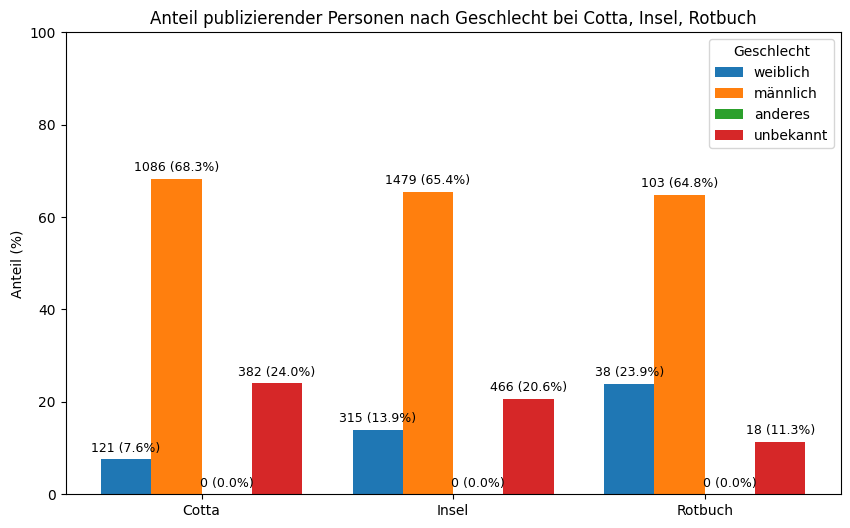

In [43]:
# Visualisierung mit Legende inkl. Werte
import numpy as np
labels = geschlechter
x = np.arange(len(autor_ids))
width = 0.2
fig, ax = plt.subplots(figsize=(10,6))
for i, g in enumerate(labels):
    werte_abs = [int(round(anteile[v][g] * len(autor_ids[v]) / 100)) if len(autor_ids[v]) > 0 else 0 for v in autor_ids]
    werte_pct = [anteile[v][g] for v in autor_ids]
    bars = ax.bar(x + i*width, werte_pct, width, label=f"{g}")
    # Werte auf die Balken schreiben
    for bar, abs_val, pct_val in zip(bars, werte_abs, werte_pct):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{abs_val} ({pct_val:.1f}%)', ha='center', va='bottom', fontsize=9)
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(list(autor_ids.keys()))
ax.set_ylabel('Anteil (%)')
ax.set_title('Anteil publizierender Personen nach Geschlecht bei Cotta, Insel, Rotbuch')
ax.legend(title='Geschlecht')
plt.ylim(0, 100)
plt.show()